In [12]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.autograd import Variable
from sklearn import metrics

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Считываем данные, задаём основные параметры, разделяем датасеты на батчи, train не забываем перемешать.

In [13]:
num_inputs = 28*28
num_outputs = 10
num_examples = 60000

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

forward — считает Xw+b

softmax — переводит выход forward в [0,1]

cross-entropy — средний loss по элементам батча

one_hot_embedding — кодирует метки объектов из k классов векторами длины k с единицами на соответствующих позициях

In [14]:
def forward(X):
    return torch.mm(X, W).add_(b)

def softmax(X):
    linear = forward(X)
    numerator = torch.exp(linear.sub(linear.max(dim=1, keepdim=True)[0]))
    denominator = numerator.sum(dim=1, keepdim=True)
    return numerator.div(denominator)

def cross_entropy(y, z):
    return -torch.mul(y, torch.log(z)).sum(dim=1).mean()

def one_hot_embedding(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

def accuracy(y, z):
    return (z.argmax(dim=1) == y.argmax(dim=1)).float().mean()

Задаём параметры модели, заводим список под хранение конечных лоссов эпохи.

Батч за батчем в каждой из эпох считаем софтмакс, далее кросс-энтропию (средний лосс).

Минимизируем последний, дифференцируя по соответствующим параметрам и изменяя веса в соответствии со значением градиента.

In [16]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})

W = Variable(torch.DoubleTensor(size=(num_inputs, num_outputs)).uniform_(), requires_grad=True)
b = Variable(torch.DoubleTensor(num_outputs).uniform_(), requires_grad=True)

pause = '\n'
epochs = 30
learning_rate = 1e-02
losses = []
accuracies = []

y_test = one_hot_embedding(test_dataset.test_labels).double()

for epoch in range(epochs):
    for index, (data, labels) in enumerate(train_loader):
        X = data.contiguous().view(batch_size, num_inputs).double()
        y = one_hot_embedding(labels).double()
        z = softmax(X)
        l = cross_entropy(y, z)
        l.backward()
        W.data = W.data - learning_rate * W.grad.data
        W.grad.data.zero_()
        b.data = b.data - learning_rate * b.grad.data
        b.grad.data.zero_()
    numerical_loss = l.detach().numpy()
    print('loss on epoch ', epoch, ': ', numerical_loss)
    losses.append(numerical_loss)
    z_test = softmax(test_dataset.test_data.view(10000, 28*28).double())
    accuracies.append(accuracy(y_test, z_test).detach().numpy())

loss on epoch  0 :  1.0339203884485446
loss on epoch  1 :  0.8520356082218844
loss on epoch  2 :  0.6052629506821482
loss on epoch  3 :  0.6616532509554217
loss on epoch  4 :  0.45040284792385316
loss on epoch  5 :  0.4207836046864115
loss on epoch  6 :  0.42861802917019914
loss on epoch  7 :  0.505735978576853
loss on epoch  8 :  0.4679393770686815
loss on epoch  9 :  0.5515279184830832
loss on epoch  10 :  0.4374235657353029
loss on epoch  11 :  0.4561315959945873
loss on epoch  12 :  0.33773504215402356
loss on epoch  13 :  0.38456678536523575
loss on epoch  14 :  0.5315506597112728
loss on epoch  15 :  0.45473629017555084
loss on epoch  16 :  0.5707612453420584
loss on epoch  17 :  0.36035972881129763
loss on epoch  18 :  0.33132440667836444
loss on epoch  19 :  0.3602038089661363
loss on epoch  20 :  0.6285787414182197
loss on epoch  21 :  0.1880880489986891
loss on epoch  22 :  0.422114418423392
loss on epoch  23 :  0.33927729700825293
loss on epoch  24 :  0.2833460061114828
loss

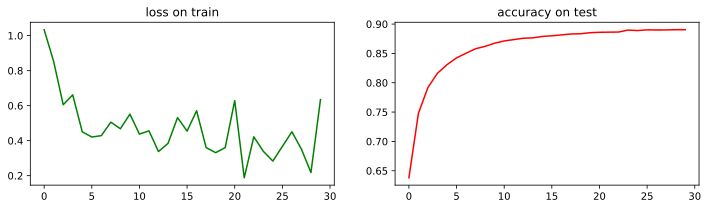

In [20]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
plt.plot(losses, 'g')
plt.title('loss on train')


plt.subplot(1, 2, 2)
plt.plot(accuracies, 'r')
plt.title('accuracy on test')

plt.show();

## accuracy

In [21]:
z_train = softmax(train_dataset.train_data.view(60000, 28*28).double())
y_train = one_hot_embedding(train_dataset.train_labels).double()
print('train accuracy: ', accuracy(y_train, z_train).detach().numpy())

train accuracy:  0.8833


In [22]:
z_test = softmax(test_dataset.test_data.view(10000, 28*28).double())
y_test = one_hot_embedding(test_dataset.test_labels).double()
print('test accuracy: ', accuracy(y_test, z_test).detach().numpy())

test accuracy:  0.8904


***

		 label:  2


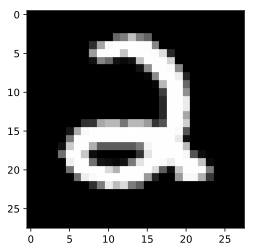

		 (28, 28) px


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
ix = np.random.randint(10000)
print('\t\t', 'label: ', test_dataset.test_labels[ix].item())
image = test_dataset.test_data[ix]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('\t\t', image.shape, 'px')

ixs = test_loader.dataset.test_data[ix].view(1, num_inputs).double()
s = (softmax(ixs)*10).int().float()/10
pd.DataFrame(s.numpy())

In [24]:
print(metrics.confusion_matrix(test_dataset.test_labels.detach(), np.argmax(z_test.detach(), axis=1)))

[[ 952    0    5    3    1    0    6    1   11    1]
 [   0 1064    3    9    0    2    3    0   54    0]
 [   8    1  892   25   10    2   13   12   56   13]
 [   3    0   18  904    0   16    2    8   45   14]
 [   3    2    5    2  863    0    9    1   22   75]
 [  13    2    4   49    7  672   16    3  115   11]
 [  12    2   11    3   21   15  873    1   20    0]
 [   3    8   31   12    8    0    0  880   12   74]
 [   6    2    6   23    5   13    8    5  893   13]
 [   8    4    6    9   28    5    0    9   29  911]]


In [25]:
print(metrics.classification_report(test_dataset.test_labels.detach(), np.argmax(z_test.detach(), axis=1)))

             precision    recall  f1-score   support

          0       0.94      0.97      0.96       980
          1       0.98      0.94      0.96      1135
          2       0.91      0.86      0.89      1032
          3       0.87      0.90      0.88      1010
          4       0.92      0.88      0.90       982
          5       0.93      0.75      0.83       892
          6       0.94      0.91      0.92       958
          7       0.96      0.86      0.90      1028
          8       0.71      0.92      0.80       974
          9       0.82      0.90      0.86      1009

avg / total       0.90      0.89      0.89     10000

